## Pronóstico de series de tiempo de precipitación con autoencoder y DMD

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
import math

gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("GPUs:", gpus)

mixed_precision.set_global_policy("mixed_float16")
print("Policy:", mixed_precision.global_policy())

2025-10-14 02:09:20.931461: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-14 02:09:21.301430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-14 02:09:21.301480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-14 02:09:21.303395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 02:09:21.450519: I tensorflow/core/platform/cpu_feature_g

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9
Policy: <Policy "mixed_float16">


2025-10-14 02:09:26.099623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 02:09:26.126960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 02:09:26.126998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-14 02:09:26.127599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [150]:
# Ruta del archivo (ya debe estar en la carpeta montada)
archivo = "../data/ERA5_daily_precipitation_1950_2022.nc"

# Abrir dataset
ds = xr.open_dataset(archivo)
ds

<xarray.Dataset> Size: 678MB
Dimensions:    (time: 26663, latitude: 155, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 620B -17.5 -17.75 -18.0 ... -55.5 -55.75 -56.0
  * time       (time) datetime64[ns] 213kB 1950-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 678MB ...

In [151]:

ds = ds.sel(time=slice("1980-01-01", "2022-12-31")) # Filtra desde 2000 a 2022
ds = ds.sel(latitude=slice(-30, -40)) # Filtra zona central
ds['tp'] = ds['tp'].where(ds['tp'] >= 0, 0) # Hace toda tp>=0
ds

<xarray.Dataset> Size: 106MB
Dimensions:    (time: 15706, latitude: 41, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 164B -30.0 -30.25 -30.5 ... -39.5 -39.75 -40.0
  * time       (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 106MB 0.2402 0.2736 ... 0.0

In [152]:
# =========================
# 2) Ordena coords: lon O→E, lat S→N
# =========================
#if float(ds.longitude[0]) > float(ds.longitude[-1]):
#    ds = ds.sortby("longitude", ascending=False)
# ERA5 suele traer lat N→S; queremos S→N (ascendente)
#if float(ds.latitude[0]) > float(ds.latitude[-1]):
#    ds = ds.sortby("latitude", ascending=False)

In [153]:
# =========================
# 3) Extrae tensor base (T, H, W, C)
# =========================
tp = ds["tp"]  # mm por paso temporal
# Asegura dtype
tp = tp.astype("float32")

# Manejo de NaNs: relleno + canal máscara (opcional)
use_mask_channel = False
if tp.isnull().any():
    use_mask_channel = True
    mask = xr.where(tp.notnull(), 1.0, 0.0).astype("float32")
    tp = tp.fillna(0.0)

# A (T,H,W)
X = tp.transpose("time", "latitude", "longitude").values  # -> (T,H,W)
T_total, H, W = X.shape

# Apila canales
channels = [X[..., None]]  # C=1
if use_mask_channel:
    M = mask.transpose("time", "latitude", "longitude").values.astype("float32")
    channels.append(M[..., None])  # C+=1
X_full = np.concatenate(channels, axis=-1).astype("float32")  # (T,H,W,C)
C = X_full.shape[-1]

print("Forma maestro:", X_full.shape)  # esperado: (8401, 41, 41, C)

Forma maestro: (15706, 41, 41, 1)


In [154]:
# =========================
# 4) Splits temporales (ajusta fechas a tu rango real)
# =========================
# Usa las fechas del dataset para que no falle si no tienes todo 2000–2022
t0 = np.datetime_as_string(ds.time.values[0], unit="D")
t1 = np.datetime_as_string(ds.time.values[-1], unit="D")
print("Rango temporal:", t0, "→", t1)

Rango temporal: 1980-01-01 → 2022-12-31


In [155]:
time_train = ["2000-01-01", "2016-12-31"]
time_val = ["2017-01-01", "2019-12-31"]
time_test = ["2020-01-01",None]

def to_array(dsi):
    arr = dsi["tp"].transpose("time", "latitude", "longitude").astype("float32")
    if use_mask_channel:
        m = xr.where(dsi["tp"].notnull(), 1.0, 0.0).transpose("time","latitude","longitude").astype("float32")
        arr = xr.concat([arr, m], dim="channel")  # (time, lat, lon, channel) pero falta expand
        arr = arr.transpose("time","latitude","longitude","channel")
        return arr.values
    else:
        return arr.values[..., None]

Xtr = to_array(ds.sel(time=slice(time_train[0], time_train[1])))
Xva = to_array(ds.sel(time=slice(time_val[0], time_val[1])))
Xte = to_array(ds.sel(time=slice(time_test[0], time_test[1])))

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (6210, 41, 41, 1) Val: (1095, 41, 41, 1) Test: (1096, 41, 41, 1)


In [156]:
# =========================
# 5) Normalización (solo con TRAIN)
#    z-score por canal; para precip muy sesgada podrías hacer log1p antes
# =========================
# Si quieres log1p solo en canal 0 (tp), descomenta:
# Xtr[...,0] = np.log1p(Xtr[...,0])
# Xva[...,0] = np.log1p(Xva[...,0])
# Xte[...,0] = np.log1p(Xte[...,0])

# Stats por canal usando train (media/σ sobre (time, lat, lon))
mu = Xtr.reshape(-1, C).mean(axis=0)
sd = Xtr.reshape(-1, C).std(axis=0) + np.finfo(float).eps

def normalize(x, mu, sd):
    return (x - mu.reshape(1,1,1,C)) / sd.reshape(1,1,1,C)

#Xtr = normalize(Xtr, mu, sd).astype("float32")
#Xva = normalize(Xva, mu, sd).astype("float32")
#Xte = normalize(Xte, mu, sd).astype("float32")

# =========================
# 6) Ventaneo temporal (N, T, H, W, C)
# =========================
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas

"""
def make_windows(X4d, T=32, S=4):
    
    #X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)
    #Ventaneo solo en tiempo, con stride S.
    
    tlen = X4d.shape[0]
    if tlen < T:
        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)
    starts = np.arange(0, tlen - T + 1, S, dtype=int)
    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)
    for j, i in enumerate(starts):
        out[j] = X4d[i:i+T]   # (T, H, W, C)
    return out

Xtr_w = make_windows(normalize(Xtr, mu, sd), T_window, stride)
Xva_w = make_windows(normalize(Xva, mu, sd), T_window, stride)
Xte_w = make_windows(normalize(Xte, mu, sd), T_window, stride)

print("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)
# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)
"""

'\ndef make_windows(X4d, T=32, S=4):\n\n    #X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)\n    #Ventaneo solo en tiempo, con stride S.\n\n    tlen = X4d.shape[0]\n    if tlen < T:\n        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)\n    starts = np.arange(0, tlen - T + 1, S, dtype=int)\n    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)\n    for j, i in enumerate(starts):\n        out[j] = X4d[i:i+T]   # (T, H, W, C)\n    return out\n\nXtr_w = make_windows(normalize(Xtr, mu, sd), T_window, stride)\nXva_w = make_windows(normalize(Xva, mu, sd), T_window, stride)\nXte_w = make_windows(normalize(Xte, mu, sd), T_window, stride)\n\nprint("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)\n# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)\n'

In [157]:
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE


def make_start_indices(T_total, T, S):
    n = max((T_total - T) // S + 1, 0)
    return np.arange(n, dtype=np.int32) * S

def dataset_from_array(X, T=32, S=4, batch=2, shuffle=4096, prefetch=2, training=True):
    # X: (T_total, H, W, C) ya normalizado (float16 recomendado)
    X_tf = tf.convert_to_tensor(X)  # no copia grande si ya es contiguous
    starts = make_start_indices(X.shape[0], T, S)

    ds = tf.data.Dataset.from_tensor_slices(starts)
    if training:
        ds = ds.shuffle(min(len(starts), shuffle), reshuffle_each_iteration=True)

    @tf.function  # forma y grafo estables
    def _extract(i):
        w = X_tf[i:i+T]              # (T,H,W,C)
        return w, w                  # AE: input = target

    ds = ds.map(_extract, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=False).prefetch(prefetch)
    return ds

train_ds = dataset_from_array(normalize(Xtr, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)
val_ds = dataset_from_array(normalize(Xva, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)  # stride mayor en val
test_ds = dataset_from_array(normalize(Xte, mu, sd), T=T_window, S=stride, batch=batch_size, shuffle=0, prefetch=AUTOTUNE, training=False)  # stride mayor en val

In [159]:
ae = load_model('../models/ae_3d_era5_tp_v1.3.keras', safe_mode=False)

In [160]:
xs, ys = [], []

for x_batch, y_batch in test_ds:
    xs.append(x_batch)
    ys.append(ae.predict(x_batch, verbose=0))

X_test = tf.concat(xs, axis=0)
Y_test = tf.concat(ys, axis=0)

In [165]:
# =========================
# 10) Eval & ejemplo de uso
# =========================
test_loss = ae.evaluate(test_ds)
print("Test loss:", test_loss)

67/67 [==============================] - 1s 11ms/step - loss: 1.4310e-05 - rmse: 0.0038
Test loss: [1.4309662219602615e-05, 0.00378281157463789]


In [166]:
#recons = ae.predict(test_ds, batch_size=8)[:,0,:,:,:]

# Flatten por ventana para evaluar MSE/MAE promedio
mse = np.mean((Y_test - X_test)**2)
mae = np.mean(np.abs(Y_test - X_test))
smape = np.mean(np.abs(2 * (Y_test - X_test) / (Y_test + X_test + np.finfo(float).eps)))

print(f"Test:")
print(f"MSE total  : {mse:.6f}")
print(f"MAE total  : {mae:.6f}")
print(f"SMAPE total: {smape*100:.3f} %")

Test:
MSE total  : 0.000014
MAE total  : 0.001892
SMAPE total: 2.768 %


In [167]:
def compare_plots_error(recons, Xte_w, d_time):
    # --- Promedios temporales globales ---
    orig_mean = np.mean(Xte_w[..., 0], axis=(0, 1))
    recon_mean = np.mean(recons[..., 0], axis=(0, 1))
    diff_mean = orig_mean - recon_mean

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    im0 = ax[0].imshow(orig_mean, cmap='viridis')
    ax[0].set_title('Original promedio')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(recon_mean, cmap='viridis')
    ax[1].set_title('Reconstruido promedio')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(diff_mean, cmap='RdBu', vmin=-np.max(abs(diff_mean)), vmax=np.max(abs(diff_mean)))
    ax[2].set_title('Diferencia (Original - Reconstruido)')
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores espaciales promedio ---
    rmse_map = np.sqrt(np.mean((recons - Xte_w)**2, axis=(0, 1, 4)))   # (H, W)
    mae_map  = np.mean(np.abs(recons - Xte_w), axis=(0, 1, 4))         # (H, W)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    im0 = ax[0].imshow(rmse_map, cmap='inferno')
    ax[0].set_title('Error RMSE promedio por píxel')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(mae_map, cmap='inferno')
    ax[1].set_title('Error MAE promedio por píxel')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores temporales promedio (por ventana) ---
    rmse_time = np.sqrt(np.mean((recons - Xte_w)**2, axis=(2, 3, 4)))  # (N, T)
    mae_time  = np.mean(np.abs(recons - Xte_w), axis=(2, 3, 4))        # (N, T)
    rmse_per_window = rmse_time.mean(axis=1)
    mae_per_window  = mae_time.mean(axis=1)

    # --- Energía media del campo original y reconstruido ---
    orig_energy  = np.mean(Xte_w[..., 0], axis=(2, 3)).mean(axis=1)
    recon_energy = np.mean(recons[..., 0], axis=(2, 3)).mean(axis=1)

    # === Evolución temporal (1): comparación original vs reconstruido ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, orig_energy, label='Original (energía media)', alpha=0.8)
    ax.plot(d_time, recon_energy, label='Reconstruido (energía media)', linestyle='--', alpha=0.9)
    ax.set_title('Evolución temporal: Original vs Reconstrucción')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Valor medio del campo')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # === Evolución temporal (2): errores RMSE y MAE juntos ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, rmse_per_window, label='RMSE', color='tab:red', alpha=0.9)
    ax.plot(d_time, mae_per_window, label='MAE', color='tab:blue', alpha=0.9)
    ax.set_title('Evolución temporal de errores (RMSE y MAE)')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Error')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # --- Distribución global de errores ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(rmse_per_window, bins=40, color='tab:red', alpha=0.7)
    ax[0].set_title('Distribución de errores RMSE por ventana')
    ax[0].set_xlabel('RMSE'); ax[0].set_ylabel('Frecuencia')

    ax[1].hist(mae_per_window, bins=40, color='tab:blue', alpha=0.7)
    ax[1].set_title('Distribución de errores MAE por ventana')
    ax[1].set_xlabel('MAE'); ax[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()


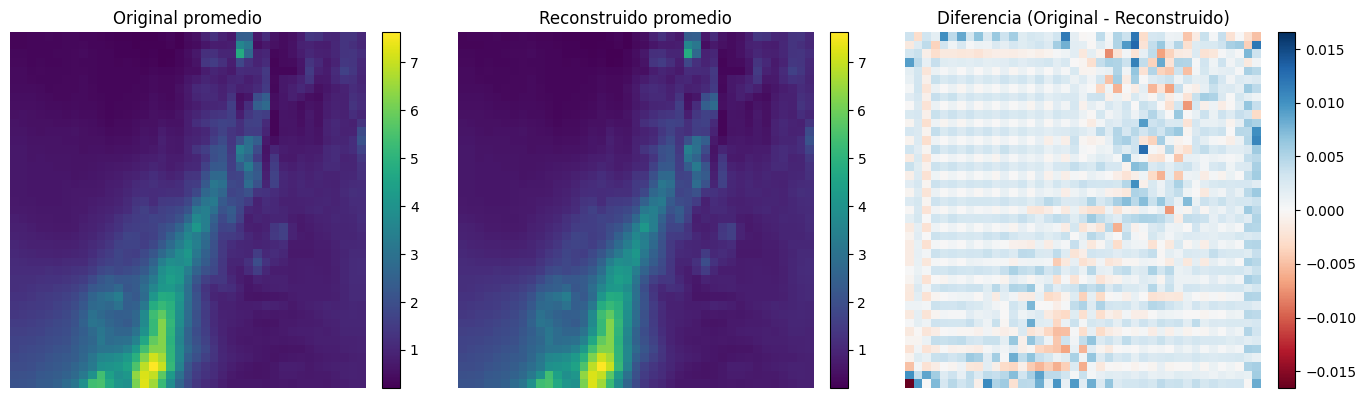

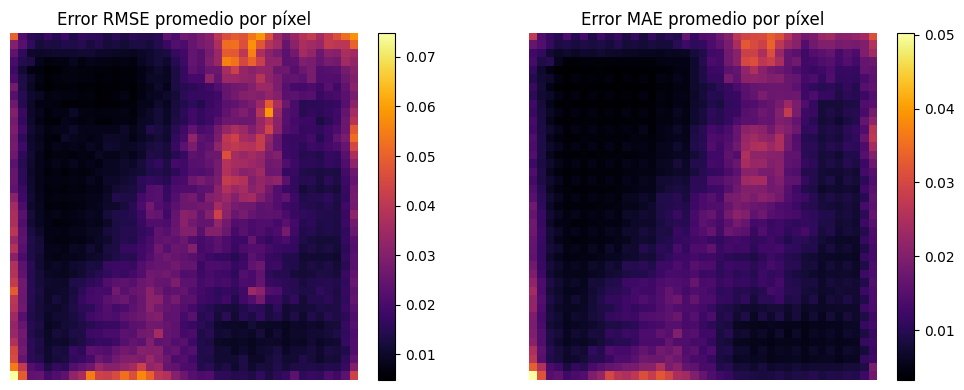

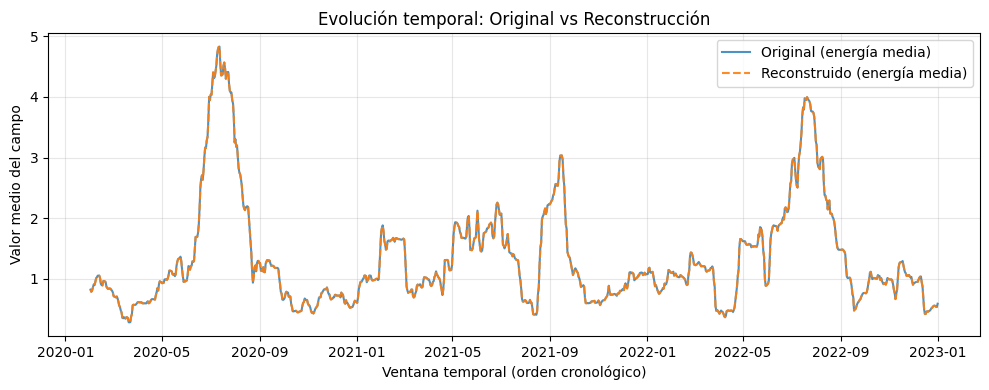

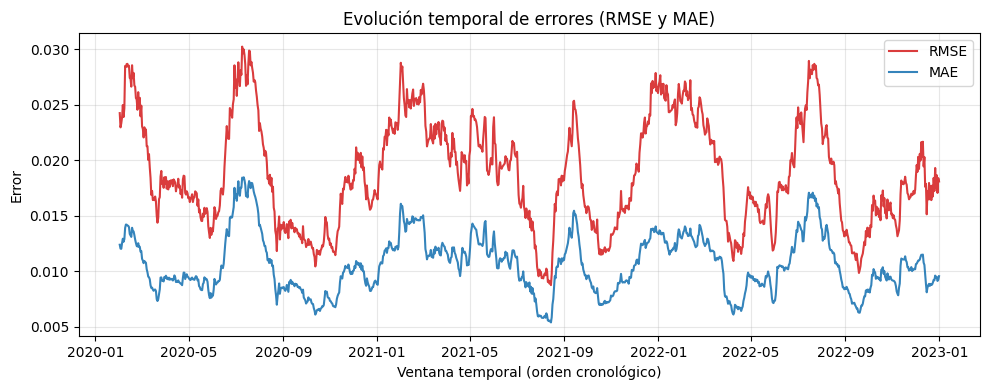

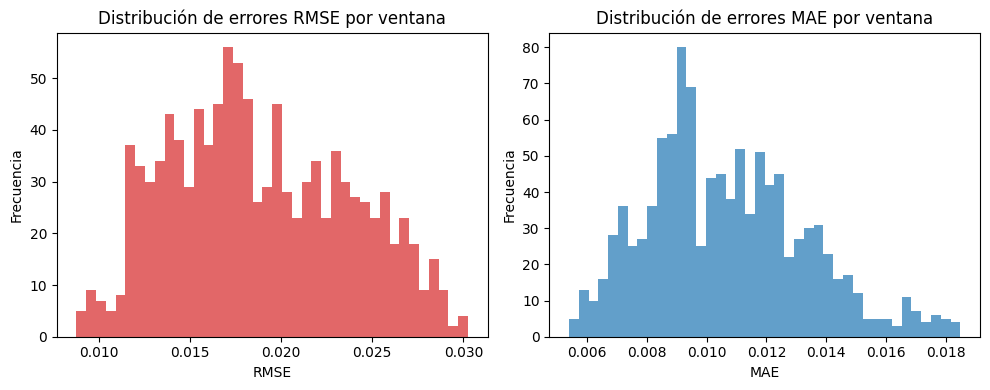

In [168]:
compare_plots_error(Y_test*sd + mu, X_test*sd + mu, ds['time'].values[-X_test.shape[0]:])

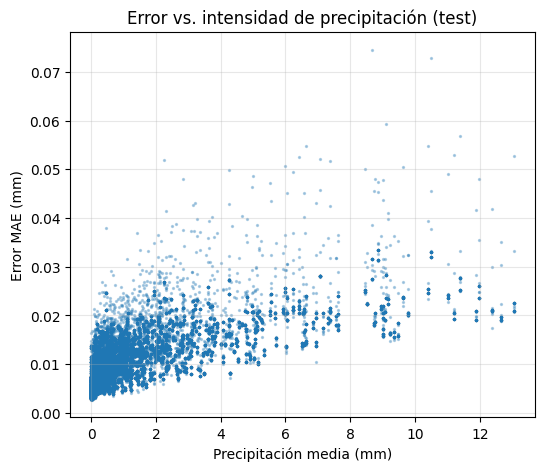

In [169]:
# Valor medio vs error (por frame)
orig_vals = np.mean(X_test[..., 0]*sd + mu, axis=(2, 3))   # (N, T)
err_vals  = np.mean(np.abs(Y_test*sd - X_test*sd), axis=(2, 3, 4)) # (N, T)

plt.figure(figsize=(6,5))
plt.scatter(orig_vals.flatten(), err_vals.flatten(), s=2, alpha=0.3)
plt.xlabel("Precipitación media (mm)")
plt.ylabel("Error MAE (mm)")
plt.title("Error vs. intensidad de precipitación (test)")
plt.grid(alpha=0.3)
plt.show()

<Figure size 2000x800 with 0 Axes>

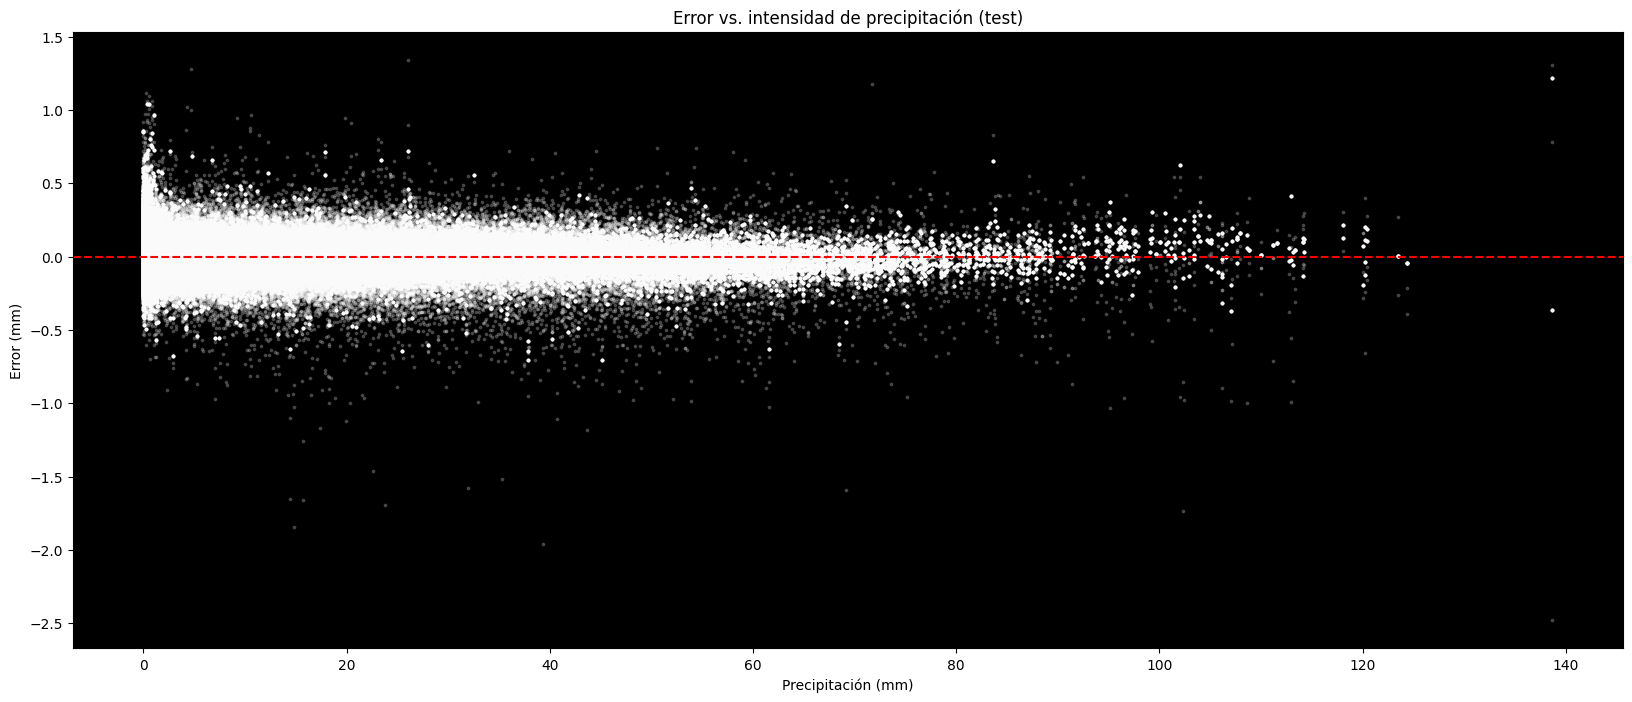

In [170]:
# Valor medio vs error (por frame)
orig_vals = (X_test[..., 0])*sd + mu
err_vals  = (Y_test*sd - X_test*sd)

plt.figure(figsize=(20,8))
fig, ax = plt.subplots(figsize=(20,8))

ax.axhline(y=0, color='r', linestyle="--")
ax.scatter(orig_vals, err_vals, s=3, alpha=0.2, color='white')
ax.set_facecolor('black')
ax.set_xlabel("Precipitación (mm)")
ax.set_ylabel("Error (mm)")
ax.set_title("Error vs. intensidad de precipitación (test)")
plt.show()

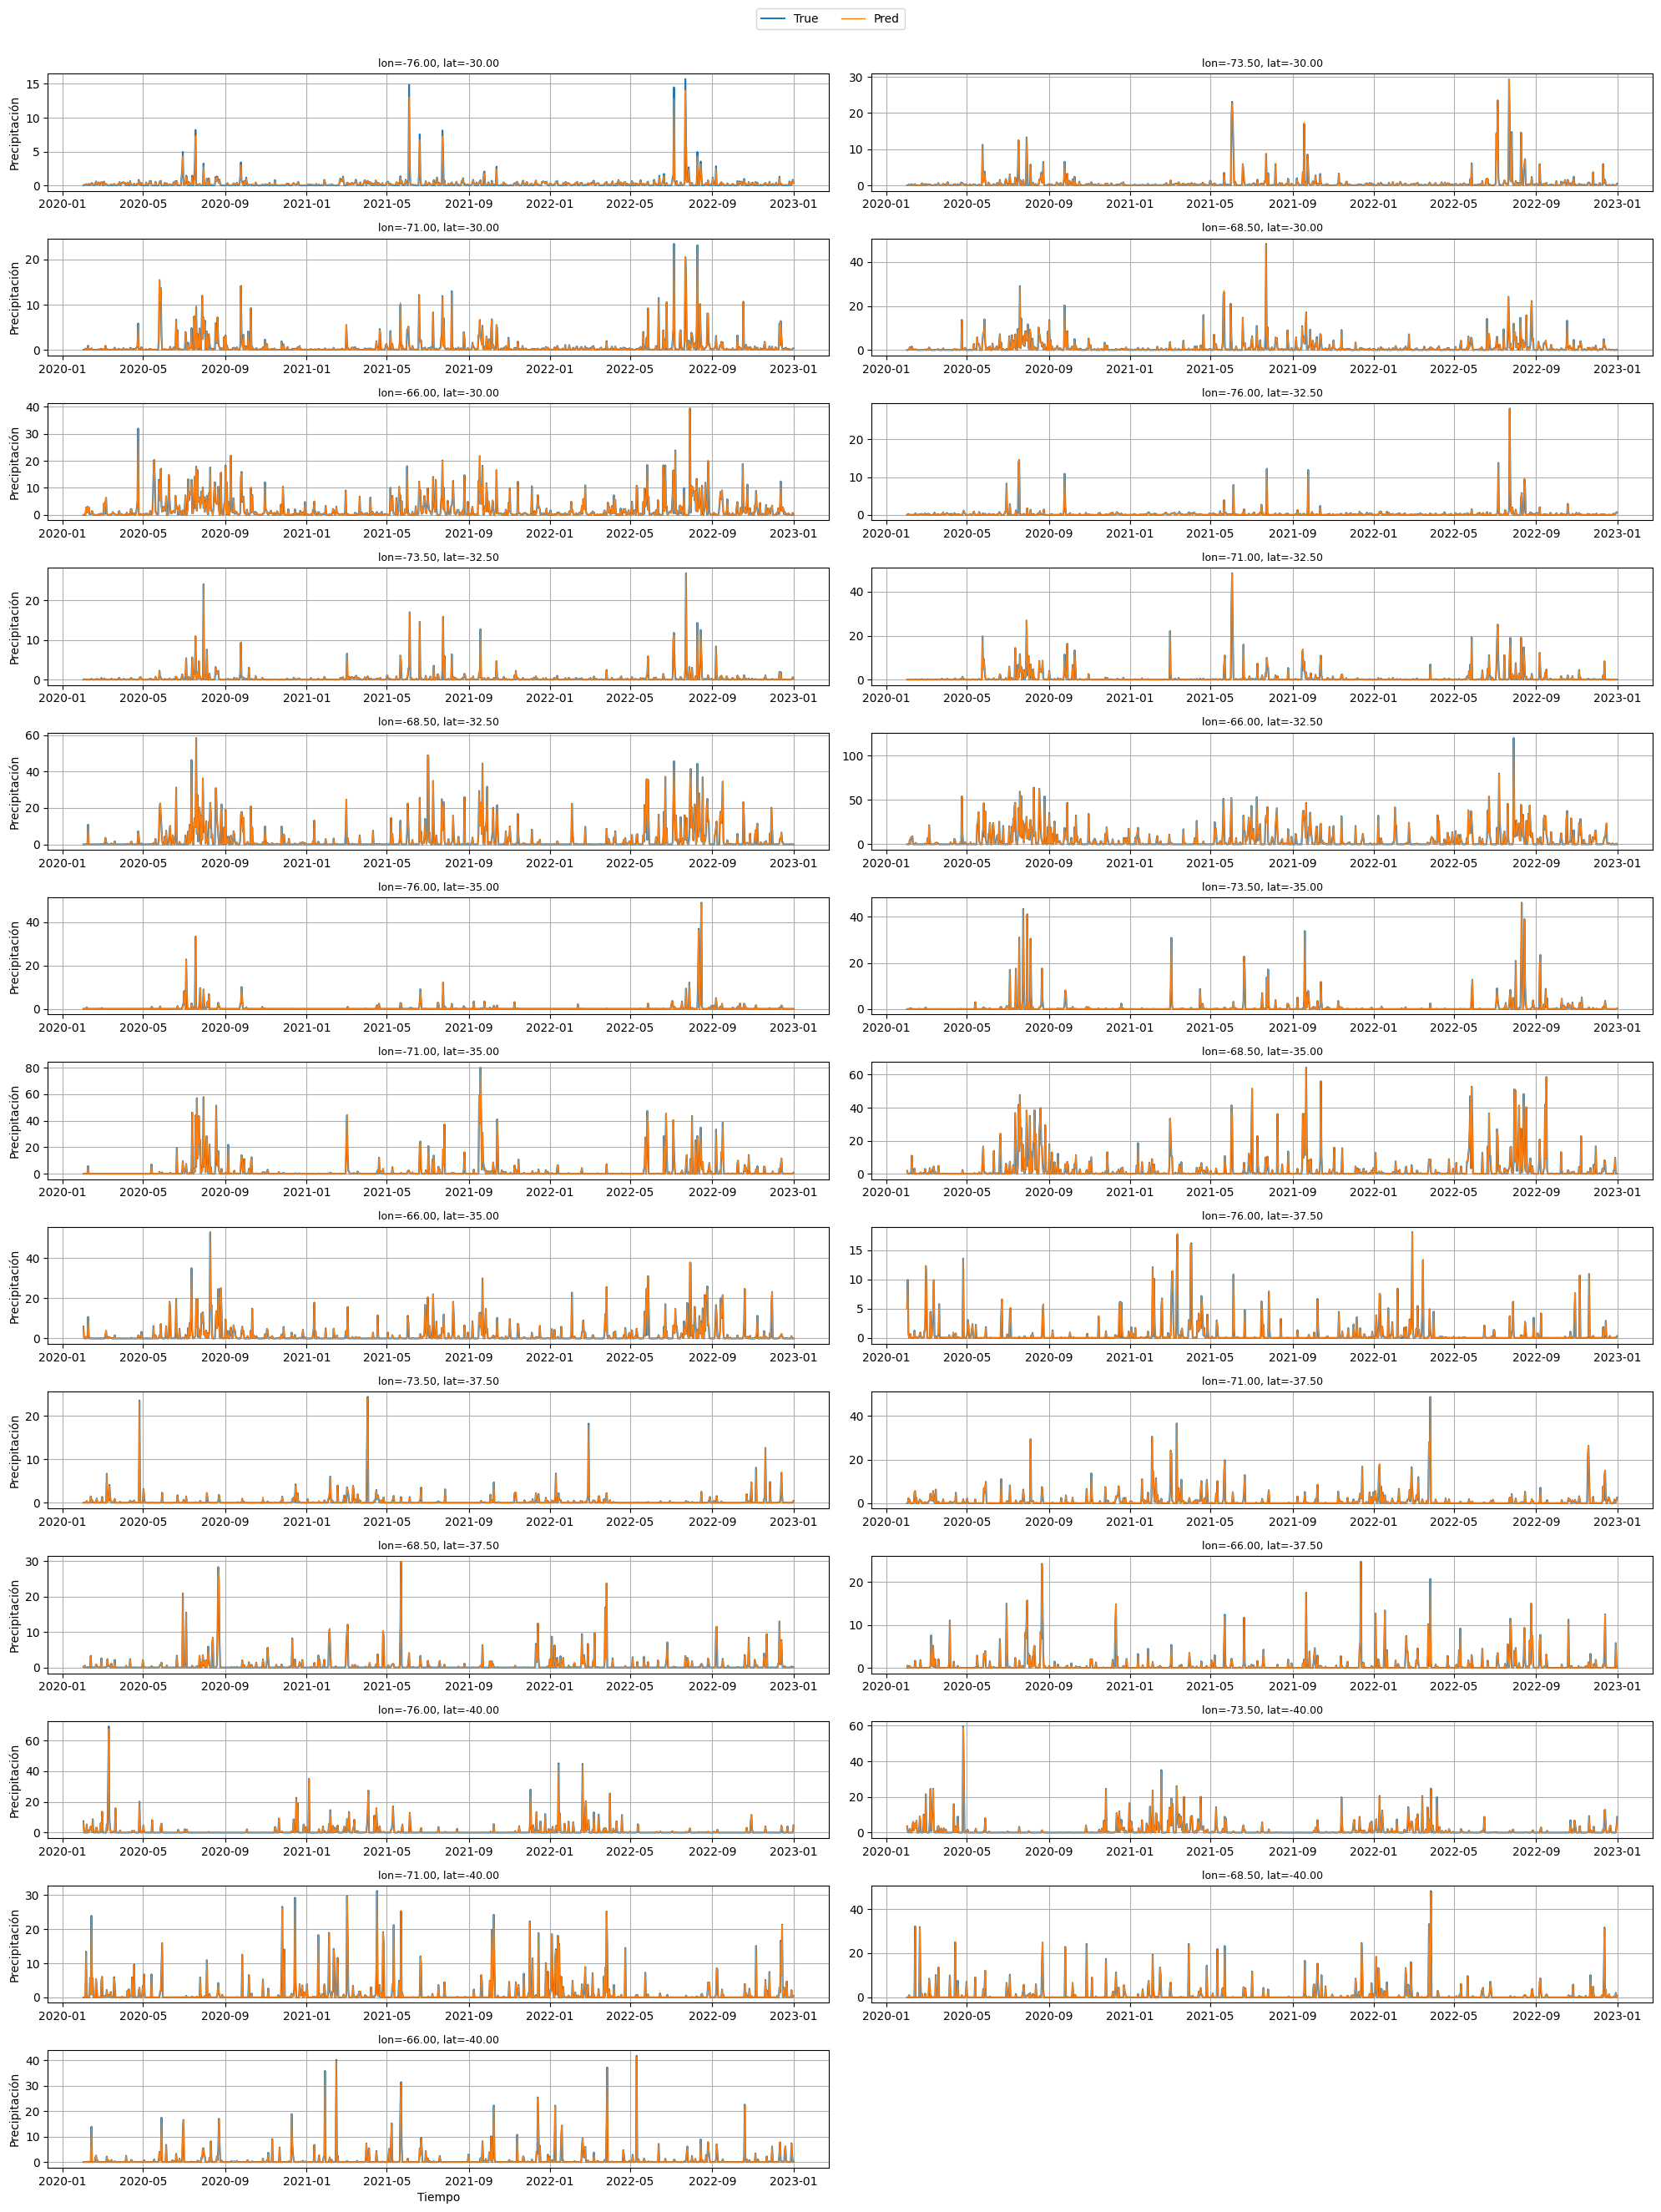

In [171]:
# --- Configuración ---
coords = [(0, 0), (10, 0), (20, 0), (30, 0), (40, 0),
          (0, 10), (10, 10), (20, 10), (30, 10), (40, 10),
          (0, 20), (10, 20), (20, 20), (30, 20), (40, 20),
          (0, 30), (10, 30), (20, 30), (30, 30), (40, 30),
          (0, 40), (10, 40), (20, 40), (30, 40), (40, 40)]
n = 13   # número de filas
m = 2   # número de columnas
assert n*m >= len(coords), "La rejilla debe tener al menos tantos subplots como coordenadas"

# --- Crear figura y ejes ---
fig, axes = plt.subplots(n, m, figsize=(20, n*2), sharex=False, sharey=False)
axes = axes.ravel()

# --- Graficar ---
for i, (lo, la) in enumerate(coords):
    ax = axes[i]
    ax.plot(ds['time'].values[-X_test.shape[0]:], (X_test*sd + mu)[:, 0, lo, la], label='True', lw=1.5)
    ax.plot(ds['time'].values[-X_test.shape[0]:], (Y_test*sd + mu)[:, 0, lo, la], label='Pred', lw=1)
    ax.set_title(f"lon={ds['longitude'].values[lo]:.2f}, lat={ds['latitude'].values[la]:.2f}", fontsize=9)
    ax.grid(True)
    if i % m == 0:
        ax.set_ylabel('Precipitación')
    if i >= (n-1)*m:
        ax.set_xlabel('Tiempo')

# --- Ocultar los subplots vacíos si sobran ---
for j in range(len(coords), n*m):
    axes[j].axis('off')

# --- Ajustes finales ---
fig.legend(['True', 'Pred'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.show()


# DMD

In [180]:
from pydmd import DMD
ae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 41, 41, 1)]      0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 32, 41, 41, 16)       448       ['input_1[0][0]']             
                                                                                                  
 Latent_Space (Conv3D)       (None, 16, 21, 21, 32)       13856     ['conv3d[0][0]']              
                                                                                                  
 conv3d_transpose (Conv3DTr  (None, 32, 42, 42, 16)       13840     ['Latent_Space[0][0]']        
 anspose)                                                                                     

In [202]:
# ------------------------------
# 1) Separar encoder y "decoder"
# ------------------------------
# Encoder: hasta la capa "Latent_Space"
encoder = tf.keras.Model(
    inputs=ae.inputs[0],
    outputs=ae.get_layer("Latent_Space").output,
    name="encoder"
)

# Decoder: reutilizamos convT y hacemos crop 42->41 (equivalente a tu match_shape)
z_in = tf.keras.Input(shape=(16, 21, 21, 32), name="z_in")

ct1 = ae.get_layer("conv3d_transpose")    # (None, 32, 42, 42, 16)
ct2 = ae.get_layer("conv3d_transpose_1")  # (None, 32, 42, 42, 1)

x = ct1(z_in)
x = ct2(x)
x = tf.keras.layers.Cropping3D(cropping=((0,0),(0,1),(0,1)), name="crop_42_to_41")(x)  # -> (None, 32, 41, 41, 1)

decoder = tf.keras.Model(z_in, x, name="decoder")

In [203]:
# --------------------------------------
# 2) Utilidades para DMD en el latente
# --------------------------------------
def build_snapshots_from_window(Zwin):
    """
    Zwin: (T', H', W', F') = (16, 21, 21, 32)
    Devuelve matriz de snapshots para PyDMD: (S, T'), con S=H'*W'*F'
    """
    Tprime, Hf, Wf, Ff = Zwin.shape
    S = Hf * Wf * Ff
    # (T', H', W', F') -> (T', S) -> (S, T')
    snaps = tf.reshape(Zwin, (Tprime, S))
    snaps = tf.transpose(snaps, (1,0))
    return snaps.numpy().astype("float32"), S, (Hf, Wf, Ff)

def decode_horizon(decoder, Zwin0, Z_future_vec):
    """
    decoder  : modelo que mapea (16,21,21,32)->(32,41,41,1)
    Zwin0    : ventana latente inicial (16,21,21,32)
    Z_future_vec : (H, S) con estados latentes futuros en vector
    Devuelve: (H, 32, 41, 41, 1)
    """
    H = Z_future_vec.shape[0]
    Hf, Wf, Ff = Zwin0.shape[1], Zwin0.shape[2], Zwin0.shape[3]
    S = Hf * Wf * Ff

    Zwin = tf.convert_to_tensor(Zwin0, dtype=tf.float32)  # (16,21,21,32)
    outs = []
    for k in range(H):
        z_next = tf.reshape(tf.convert_to_tensor(Z_future_vec[k], dtype=tf.float32), (Hf, Wf, Ff))
        # ventana deslizante: quitar 1º, agregar predicción
        Zwin = tf.concat([Zwin[1:], tf.expand_dims(z_next, 0)], axis=0)  # (16,21,21,32)
        outs.append(Zwin)

    latent_windows = tf.stack(outs, axis=0)  # (H,16,21,21,32)
    X_pred = decoder.predict(latent_windows, verbose=0)  # (H,32,41,41,1)
    return X_pred

# ------------------------------------------------
# 3) Pipeline: encode -> PyDMD -> rollout -> decode
# ------------------------------------------------
def ae_pydmd_forecast(ae, encoder, decoder, X_windows, svd_rank=80, horizon=8):
    """
    X_windows : (N, 32, 41, 41, 1)  ventanas de entrada
    svd_rank  : r de DMD reducido
    horizon   : pasos futuros
    Retorna   : preds (H, 32, 41, 41, 1) y estados futuros (H, 21, 21, 32)
    """
    # 3.1 Encodear
    Z = encoder.predict(X_windows, verbose=0).astype("float32")   # (N, 16, 21, 21, 32)

    # 3.2 Tomar una ventana latente (la 0 para pruebas)
    Zwin0 = Z[0]  # (16,21,21,32)

    # 3.3 Snapshots para PyDMD: (S, T')
    snaps, S, hwf = build_snapshots_from_window(Zwin0)  # (S, 16)

    # 3.4 Ajustar DMD reducido
    dmd = DMD(svd_rank=svd_rank)  # tlsq=0 por defecto; exact DMD
    dmd.fit(snaps)                # columnas = snapshots temporales

    # 3.5 Extender horizonte temporal en PyDMD
    # tiempo original: 0..T'-1 ; extendemos a T'+horizon-1
    Tprime = snaps.shape[1]
    dmd.dmd_time['t0'] = 0
    dmd.dmd_time['tend'] = Tprime + horizon - 1
    dmd.dmd_time['dt'] = 1

    # 3.6 Reconstrucción extendida y extracción de futuros
    snaps_ext = dmd.reconstructed_data.real  # (S, T'+H)
    Z_future_vec = snaps_ext[:, Tprime: Tprime + horizon].T      # (H, S)

    # 3.7 Decodificar con ventana deslizante
    X_pred = decode_horizon(decoder, Zwin0, Z_future_vec)        # (H,32,41,41,1)

    # (Opcional) estados latentes futuros en forma (H,21,21,32)
    Hf, Wf, Ff = hwf
    Z_future_reshaped = tf.reshape(Z_future_vec, (horizon, Hf, Wf, Ff)).numpy().astype("float32")

    return X_pred, Z_future_reshaped

In [229]:
# =======================
# 4) Ejecución de prueba
# =======================
# Datos de ejemplo (reemplaza por los tuyos)
# X_test: (N, 32, 41, 41, 1)
# X_test = np.load("...")  # o lo que uses
# Para demo, crea datos aleatorios:
# X_test = np.random.randn(8, 32, 41, 41, 1).astype("float32")

horizon = 10
X_test_ = X_test[:100]
preds, Zf = ae_pydmd_forecast(ae, encoder, decoder, X_test_, svd_rank=500, horizon=horizon)
print(preds.shape)  # (5, 32, 41, 41, 1)
print(Zf.shape)     # (5, 21, 21, 32)

# ======================
# 5) Extraer solo H días
# ======================
# Si quieres comparar SOLO los H días nuevos:
y_pred = preds[:, -1, ...]   # (H, 41, 41, 1)

(10, 32, 41, 41, 1)
(10, 21, 21, 32)


In [230]:
def extract_future_from_preds(preds):
    """
    preds: (H, 32, 41, 41, 1)
    Devuelve solo el último día de cada ventana predicha → (H, 41, 41, 1)
    """
    return preds[:, -1, ...]

def build_future_from_dataset(X, base_window, horizon):
    """
    X: (N, T, H, W, C)
    base_window: índice de la ventana usada para predecir (normalmente 0)
    horizon: número de días futuros predichos
    Devuelve los H días reales futuros (H, H, W, C)
    """
    N = X.shape[0]
    if base_window + horizon >= N:
        raise ValueError("No hay suficientes ventanas para construir la verdad futura.")
    fut = [X[base_window + h + 1, -1, ...] for h in range(horizon)]
    return np.stack(fut, axis=0).astype("float32")

def evaluate_forecast(y_true, y_pred, eps=1e-6):
    """
    Calcula RMSE, MAE y sMAPE.
    """
    diff = y_pred - y_true
    rmse = np.sqrt(np.mean(diff**2))
    mae  = np.mean(np.abs(diff))
    smape = 2 * np.mean(np.abs(diff) / (np.abs(y_pred) + np.abs(y_true) + eps))
    return {"RMSE": float(rmse), "MAE": float(mae), "sMAPE": float(smape)}

In [231]:
base_window = 0     # la que usaste para generar preds

# 1) Extraer sólo los días nuevos de la predicción
y_pred = extract_future_from_preds(preds)                # (5, 41, 41, 1)

# 2) Construir la verdad futura a partir del dataset
y_true = build_future_from_dataset(X_test_, base_window, horizon)    # (5, 41, 41, 1)

# 3) Calcular métricas
metrics = evaluate_forecast(y_true, y_pred)
print(metrics)


{'RMSE': 0.8947901725769043, 'MAE': 0.28329557180404663, 'sMAPE': 0.5976296067237854}


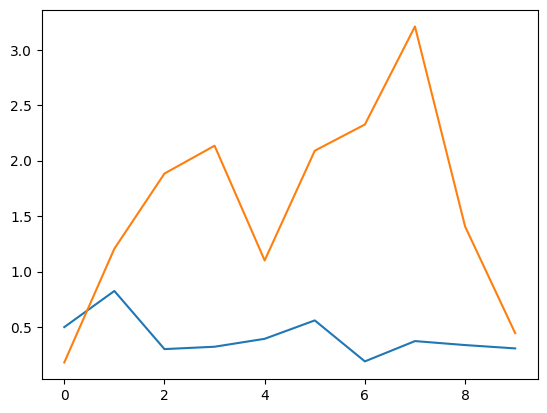

In [232]:
plt.plot(y_pred.mean(axis=(1,2))*sd + mu)
plt.plot(y_true.mean(axis=(1,2))*sd + mu)